In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/')

In [3]:
from InterpolationNetworks import *
import matplotlib.pyplot as plt ###Should print "cuda" otherwise something is wrong

Final Interpolation Networks Classes
----------------------------- 
File Includes the following Classes
*ControlNN
*QuantumSystem
*InterpolationNetwork (ABSTRACT)
*InterpNN1D
*FrozenNN1D
*InterpNN2D
*FrozenNN2D
----------------------------- 
Current Device: cuda


In [4]:
"""Setup parameters"""
N = 11
n_steps = 51
dt = 0.2

"""Create list of drive Hamiltonians for system and store on gpu"""
H_drives = np.array([PAULIS["X"],PAULIS["Y"]],dtype='cfloat')
gpu_H_drives = torch.tensor(H_drives).to(device)  ###Always pass these to functions, these are stored on gpu

"""Create a function to compute Rz(theta) and store on gpu"""
m = -1j/2 * PAULIS["Z"]
vals, vecs = np.linalg.eig(m)

vecs_tensor = torch.tensor(vecs).to(device)
vecsT_tensor = torch.tensor(vecs.T.conjugate()).to(device)
vals_tensor = torch.tensor(vals).to(device)

def gpu_excitation(theta):
  return vecs_tensor @ torch.diag(torch.exp(theta * vals_tensor)) @ vecsT_tensor


"""Quantum System Class contrains all the dynamics variables"""
system = QuantumSystem(
    dt=dt, ###Timestep
    n_steps=n_steps, ###Number of steps
    operator=gpu_excitation, ###Target operator
    H_drives=gpu_H_drives ###Drive Hamiltonians
)

"""Create a randomized model"""
randomized_model = InterpolationNetwork1D(
    N=N, ###Number of sampled points (for pretraining)
    layers = 1, ###Number of hidden layers (ater first)
    width = 50, ###Network width
    system=system ###Quantum system
)

"""Path to csv with pretraining pulses"""
pretraining_path = "/content/drive/MyDrive/XYControlRZ/FinalXYControlRZ_accels.csv"

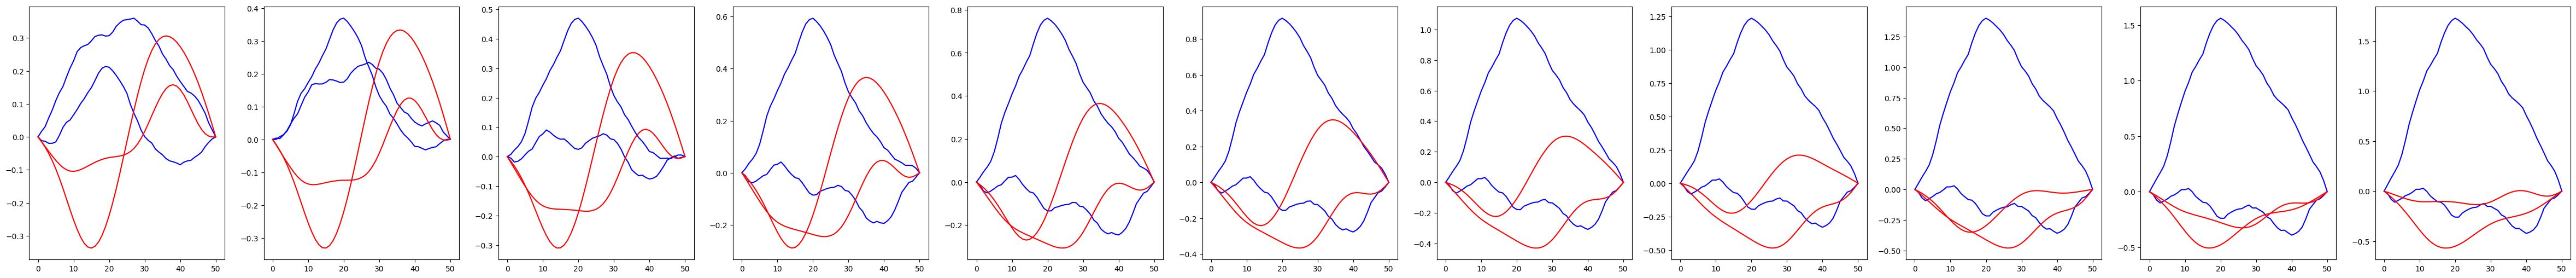

In [5]:
fig, ax = plt.subplots(1,N,figsize=(60,6))
model_controls,pretrain_controls = randomized_model.get_comparison_controls(pretraining_path) ###Get the model/pretrain controls
for i in range(N):
    ax[i].plot(model_controls[i],color='blue')
    ax[i].plot(pretrain_controls[i],color='red')

In [6]:
###save the randomized model (Make sure you have the right folder)
before_pretrained=randomized_model.model.state_dict()

In [7]:
###Pretrain the randomized model
pretrain_loss=randomized_model.pretrain(
    pretraining_path = pretraining_path, ###Path of pretraining data
    lr = 1e-3, ###Learnrate, defaults to 1e-3 (does not need to be set)
    iters=50000,#10**6//2,###Optimization iterations, defaults to 5*10**5 (does not need to be set)
    thresh=1e-6
)

Epochs: 0 Loss: 0.3756645917892456
-------------------
Epochs: 1000 Loss: 0.0001270649954676628
-------------------
Epochs: 2000 Loss: 2.6991783670382574e-05
-------------------
Epochs: 3000 Loss: 1.921859075082466e-05
-------------------
Epochs: 4000 Loss: 9.847972251009196e-06
-------------------
Epochs: 5000 Loss: 7.178729720180854e-05
-------------------
Epochs: 6000 Loss: 4.755091140395962e-06
-------------------
Epochs: 7000 Loss: 2.546918040025048e-05
-------------------
Epochs: 8000 Loss: 1.0029646546172444e-05
-------------------
Epochs: 9000 Loss: 2.646633674885379e-06
-------------------
Epochs: 10000 Loss: 2.6381621864857152e-05
-------------------
Epochs: 11000 Loss: 1.7249477650693734e-06
-------------------
Epochs: 12000 Loss: 3.16911973641254e-06
-------------------
Epochs: 13000 Loss: 1.9657825305330334e-06
-------------------
Epochs: 14000 Loss: 3.2501739042345434e-06
-------------------
Epochs: 15000 Loss: 1.0762743158920784e-06
-------------------
Epochs: 16000 Loss

Text(0.5, 1.0, 'Pretraining Loss')

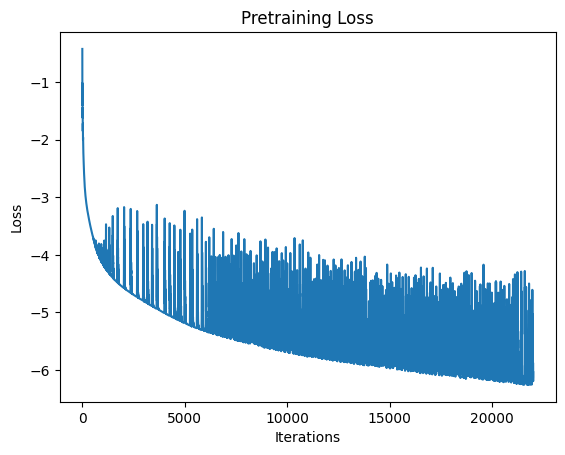

In [8]:
plt.plot(np.log10(np.array(pretrain_loss))) ###Plot the pretraining loss
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Pretraining Loss")

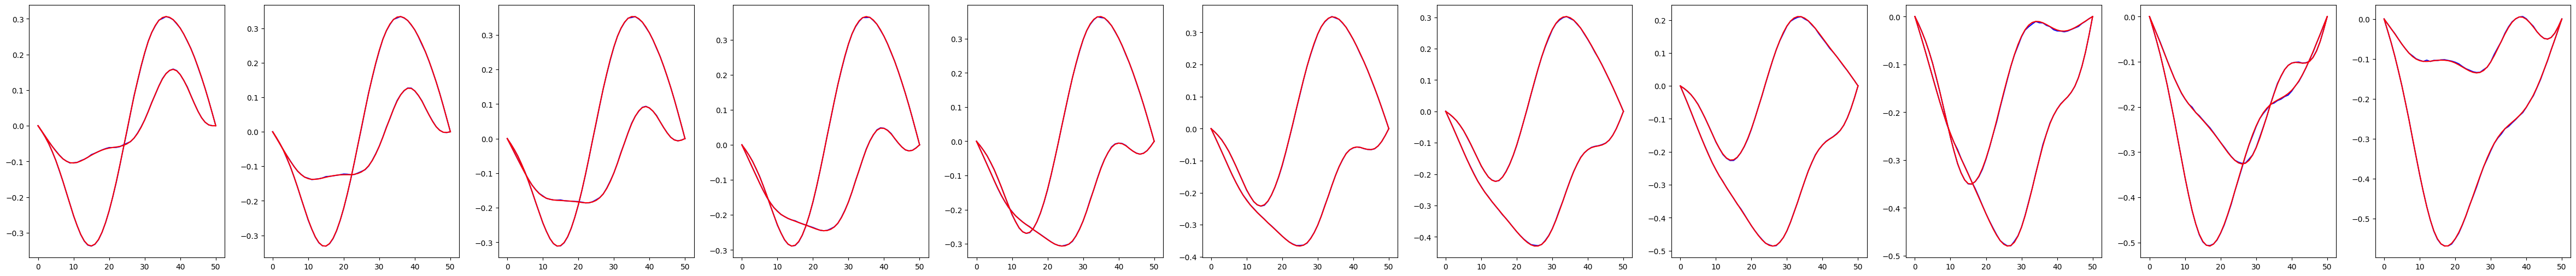

In [9]:
fig, ax = plt.subplots(1,N,figsize=(60,6))
model_controls,pretrain_controls = randomized_model.get_comparison_controls(pretraining_path) ###Get the model/pretrain controls
for i in range(N):
    ax[i].plot(model_controls[i],color='blue')
    ax[i].plot(pretrain_controls[i],color='red')

In [10]:
model_infid,pretrain_infid=randomized_model.get_comparison_samples(pretraining_path) ###Get the Infidelities for the model and the pretraining data
print(f"Model: {model_infid} \n Pretraining Data: {pretrain_infid}")

Model: tensor([1.0252e-04, 1.2964e-04, 1.0955e-04, 6.5804e-05, 1.2159e-05, 9.6560e-05,
        1.3494e-04, 1.2386e-04, 9.4473e-05, 8.7976e-05, 8.6367e-05],
       device='cuda:0', grad_fn=<MaximumBackward0>) 
 Pretraining Data: tensor([8.7619e-05, 7.8738e-05, 8.8573e-05, 6.7949e-05, 7.2718e-06, 8.1778e-05,
        6.2704e-05, 8.2612e-05, 8.9526e-05, 8.4758e-05, 9.8705e-05])


Text(0.5, 1.0, 'Only Pretrained Log Infidelity')

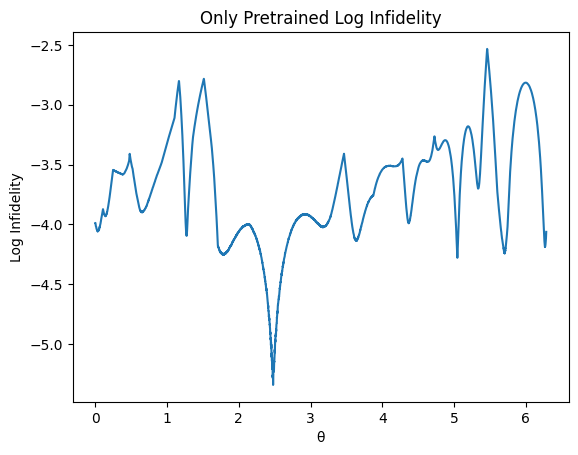

In [11]:
###Logplot infidelity
theta_list=torch.linspace(0,2*pi,5000).to(device)
log_infidelity_vals=randomized_model.infid_data(theta_list)
plt.plot(torch.Tensor.cpu(theta_list).detach().numpy(),torch.Tensor.cpu(log_infidelity_vals).detach().numpy(),label='pretrained')
plt.xlabel('θ')
plt.ylabel('Log Infidelity')
plt.title("Only Pretrained Log Infidelity")

In [12]:
###Export the pretraining model (Make sure you have the right folder)
just_pretrained=randomized_model.model.state_dict()

In [25]:
###Make 4 models for each training combo
trained_model = InterpolationNetwork1D(
    N=N, ###Number of sampled points (for pretraining)
    layers = 1, ###Number of hidden layers (ater first)
    width = 50, ###Network width
    system=system ###Quantum system
)

pretrained_trained_model = InterpolationNetwork1D(
    N=N, ###Number of sampled points (for pretraining)
    layers = 1, ###Number of hidden layers (ater first)
    width = 50, ###Network width
    system=system ###Quantum system
)

before_pretrained=trained_model.model.state_dict()
pretrained_trained_model.model.load_state_dict(just_pretrained)


<All keys matched successfully>

In [14]:
###Train the model
trained_model_train_losses,trained_model_test_losses,trained_model_epoch_losses,trained_model_history=trained_model.train(
    lr=5e-4,  ###Learn Rate, does not need to be set (defaults to 5e-5)
    iters=500, ###Iterations, does not need to be set(defaults to 10**5)
    train_size=500,test_size=4500,batch_size=50,c=1e-5
)

Epoch: 0
Total Loss: 0.2553613781929016
-------------------
Epoch: 100
Total Loss: 9.163838694803417e-05
-------------------
Epoch: 200
Total Loss: 0.00021682475926354527
-------------------
Epoch: 300
Total Loss: 0.00039582737372256815
-------------------
Epoch: 400
Total Loss: 5.885334394406527e-05
-------------------


In [15]:
###Train the model
pretrained_trained_model_train_losses,pretrained_trained_model_test_losses,pretrained_trained_model_epoch_losses,pretrained_trained_model_history=pretrained_trained_model.train(
    lr=5e-4,  ###Learn Rate, does not need to be set (defaults to 5e-5)
    iters=500, ###Iterations, does not need to be set(defaults to 10**5)
    train_size=500,test_size=4500,batch_size=50,c=1e-5
)

Epoch: 0
Total Loss: 0.0026907920837402344
-------------------
Epoch: 100
Total Loss: 7.144437404349446e-05
-------------------
Epoch: 200
Total Loss: 3.5992754419567063e-05
-------------------
Epoch: 300
Total Loss: 2.8914511858602054e-05
-------------------
Epoch: 400
Total Loss: 4.98301706102211e-05
-------------------


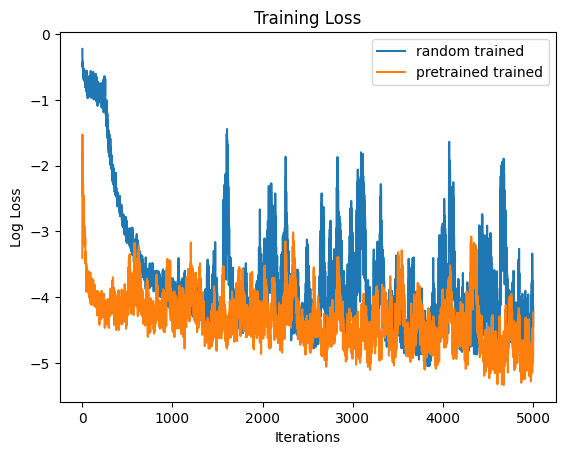

In [16]:
plt.plot(range(1,5000+1),np.log10(np.array(trained_model_train_losses)),label='random trained')
plt.plot(range(1,5000+1),np.log10(np.array(pretrained_trained_model_train_losses)),label='pretrained trained')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title("Training Loss")
plt.legend()

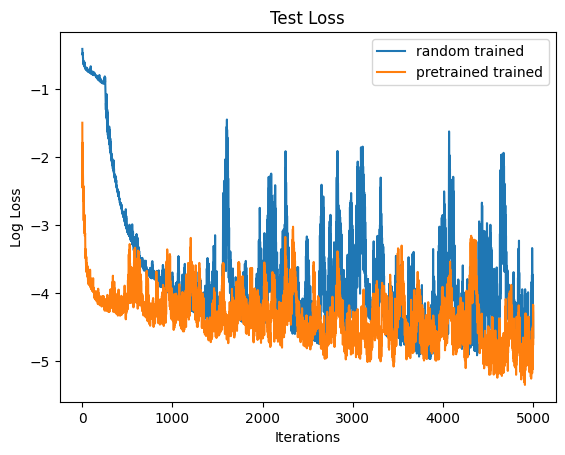

In [17]:
plt.plot(range(1,5000+1),np.log10(np.array(trained_model_test_losses)),label='random trained')
plt.plot(range(1,5000+1),np.log10(np.array(pretrained_trained_model_test_losses)),label='pretrained trained')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title("Test Loss")
plt.legend()

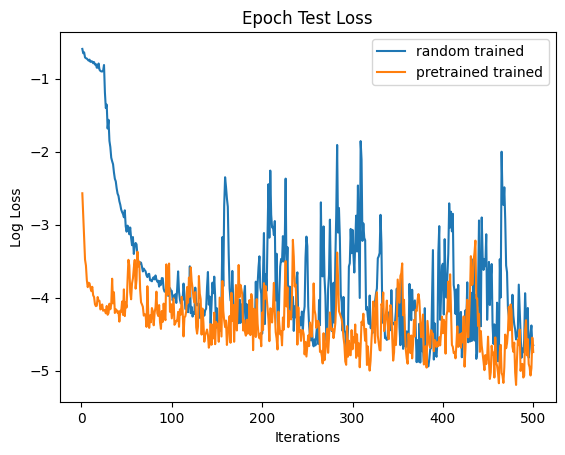

In [18]:
plt.plot(range(1,501),np.log10(np.array(trained_model_epoch_losses)),label='random trained')
plt.plot(range(1,501),np.log10(np.array(pretrained_trained_model_epoch_losses)),label='pretrained trained')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title("Epoch Test Loss")
plt.legend()

Text(0.5, 1.0, 'Log Infidelity')

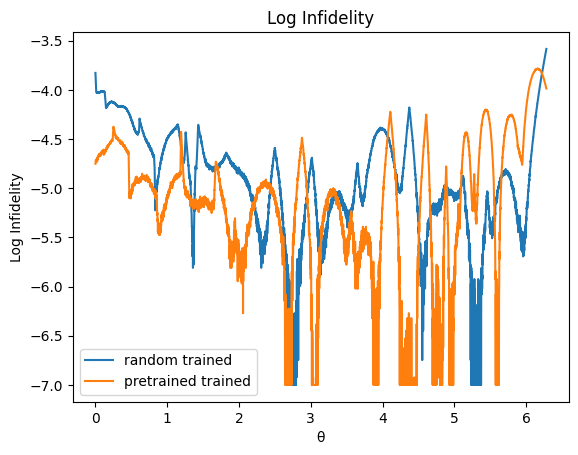

In [19]:
theta_list=torch.linspace(0,2*pi,5000).to(device)
log_infidelity_vals1=trained_model.infid_data(theta_list)
plt.plot(torch.Tensor.cpu(theta_list).detach().numpy(),torch.Tensor.cpu(log_infidelity_vals1).detach().numpy(),label='random trained')
log_infidelity_vals2=pretrained_trained_model.infid_data(theta_list)
plt.plot(torch.Tensor.cpu(theta_list).detach().numpy(),torch.Tensor.cpu(log_infidelity_vals2).detach().numpy(),label='pretrained trained')
plt.legend()
plt.xlabel('θ')
plt.ylabel('Log Infidelity')
plt.title("Log Infidelity")

In [20]:
trained_model_first = trained_model_history[[i for i,v in enumerate(trained_model_epoch_losses) if v<=1e-4][0]]
pretrained_trained_model_first = pretrained_trained_model_history[[i for i,v in enumerate(pretrained_trained_model_epoch_losses) if v <= 1e-4][0]]


trained_model_last = trained_model_history[-1]
pretrained_trained_model_last = pretrained_trained_model_history[-1]


In [21]:
print(f"""trained_model_first: {[i for i,v in enumerate(trained_model_epoch_losses) if v <= 1e-4][0]-1}
pretrained_trained_model_first: {[i for i,v in enumerate(pretrained_trained_model_epoch_losses) if v <= 1e-4][0]}
""")

trained_model_first: 99
pretrained_trained_model_first: 14



In [22]:
trained_model.model.load_state_dict(trained_model_first)
pretrained_trained_model.model.load_state_dict(pretrained_trained_model_first)


<All keys matched successfully>

Text(0.5, 1.0, 'Log Infidelity')

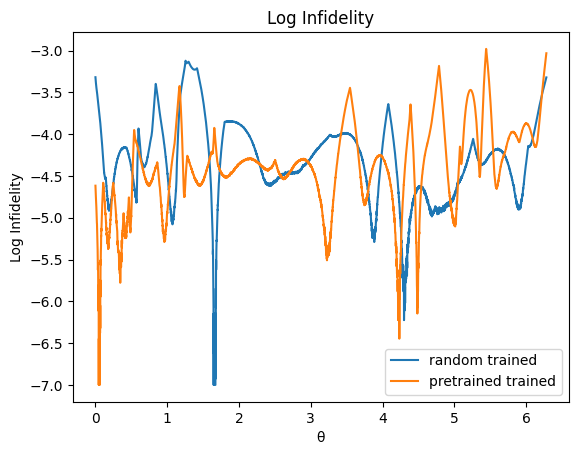

In [23]:
theta_list=torch.linspace(0,2*pi,5000).to(device)
log_infidelity_vals1=trained_model.infid_data(theta_list)
plt.plot(torch.Tensor.cpu(theta_list).detach().numpy(),torch.Tensor.cpu(log_infidelity_vals1).detach().numpy(),label='random trained')
log_infidelity_vals2=pretrained_trained_model.infid_data(theta_list)
plt.plot(torch.Tensor.cpu(theta_list).detach().numpy(),torch.Tensor.cpu(log_infidelity_vals2).detach().numpy(),label='pretrained trained')
plt.legend()
plt.xlabel('θ')
plt.ylabel('Log Infidelity')
plt.title("Log Infidelity")

In [26]:
torch.save({
            'before_pretrained': before_pretrained,
            'just_pretrained': just_pretrained,
            'trained_model_last': trained_model_last,
            'pretrained_trained_model_last': pretrained_trained_model_last,
            'trained_model_first': trained_model_first,
            'pretrained_trained_model_first': pretrained_trained_model_first,
            }, "/content/drive/MyDrive/FinalXYControlRZ/model_states")

epoch_data = pd.DataFrame(data={"trained_model": trained_model_epoch_losses,
              "pretrained_trained_model": pretrained_trained_model_epoch_losses}
)
training_data = pd.DataFrame(data = {"trained_model":trained_model_train_losses,
                 "pretrained_trained_model":pretrained_trained_model_train_losses,
                })
test_data = pd.DataFrame(data = {
    "trained_model":trained_model_test_losses,
    "pretrained_trained_model":pretrained_trained_model_test_losses,
})
training_data.to_csv("/content/drive/MyDrive/FinalXYControlRZ/Train_Loss")
test_data.to_csv("/content/drive/MyDrive/FinalXYControlRZ/Test_Loss")
epoch_data.to_csv("/content/drive/MyDrive/FinalXYControlRZ/Epoch_Loss")